In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   ##绘图库
import seaborn as sns ##图片风格扩展
from datetime import timedelta  #时间
from sklearn.preprocessing import LabelEncoder  ##label编码
from matplotlib import font_manager  ##解决plot中文字符显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为新宋体。
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时'-'显示为方块的问题。
from matplotlib import colors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split   ## 划分
from sklearn.metrics import r2_score
import torch
## 代替keras库,LSTM模型
from torch import nn
from sklearn.preprocessing import MinMaxScaler

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # 使用 CPU
    print("Using CPU")



Using GPU: NVIDIA GeForce MX450


整理天气数据 - 缺失值和异常值处理 - 对列重命名

In [3]:
# 加载 csv文件
weather_data = pd.read_csv('weatherdata.csv')

# 将时间列转化为日期时间格式
weather_data['当地时间 北京'] = pd.to_datetime(weather_data['当地时间 北京'], format='%d.%m.%Y %H:%M')  # 处理中文版本csv文件 

# 遍历数据集中的每一个列
for col in weather_data.columns:
    # 如果数据类型是非数值型并且列名不是'当地时间 北京'
    if pd.api.types.is_string_dtype(weather_data[col]) and col != '当地时间 北京':  # 对中文版csv文件操作
        # 使用factorize对非数值型的列进行编码
        weather_data[col] = pd.factorize(weather_data[col])[0]

# 下面的步骤只会对数值类型的列进行操作
numeric_columns = weather_data.columns[weather_data.dtypes != 'object']

# 使用每列的平均值填充对应列的缺失值
weather_data[numeric_columns] = weather_data[numeric_columns].fillna(weather_data[numeric_columns].mean())
# 删除含有 NaN 的列
weather_data = weather_data.dropna(axis=1)

# 定义新的列名
column_dict = {'当地时间 北京':'日期','T': '气温', 'Po': '气压', 'P': '平均海平面大气压', 'Pa': '气压趋势', 'U': '湿度', 'DD': '风向', 'Ff': '平均风速', 'ff3': '最大阵风', 'WW': '天气情况', 'Tn': '最低气温', 'Tx': '最高气温', 'Td': '露点温度', 'tR': '降水时间'}

# 更改列名
weather_data = weather_data.rename(columns=column_dict)

# 从'日期'列中提取日期
weather_data['日期'] = pd.to_datetime(weather_data['日期']).dt.date

# 计算每日平均值
daily_avg_data = weather_data.groupby('日期').mean().reset_index()

daily_avg_data = daily_avg_data.round(3)

# 检查结果
daily_avg_data

,日期,气温,气压,平均海平面大气压,气压趋势,湿度,风向,平均风速,最大阵风,天气情况,最低气温,最高气温,露点温度,降水时间
0,2013-12-02,3.162,759.712,764.462,-0.013,45.875,7.375,1.375,7.177,5.500,6.896,18.301,-8.588,10.717
1,2013-12-03,5.488,761.725,766.425,0.100,39.000,8.000,1.625,7.177,4.750,7.209,18.314,-8.900,10.717
2,2013-12-04,5.250,760.300,764.988,-0.138,45.375,9.375,1.250,7.177,1.750,7.134,18.714,-6.675,10.717
3,2013-12-05,6.150,763.275,767.975,0.250,30.000,6.875,2.250,7.177,3.875,7.759,18.551,-10.912,10.717
4,2013-12-06,2.925,760.325,765.075,-0.275,52.750,4.875,1.250,7.177,1.000,7.121,18.239,-6.350,10.717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,2023-12-26,-2.050,770.638,773.938,0.925,54.125,8.250,1.500,7.147,0.500,-9.475,2.588,-10.862,12.000
3677,2023-12-27,-3.888,771.538,774.850,-0.538,67.750,7.250,1.125,4.250,0.000,-8.900,5.348,-9.450,12.000
3678,2023-12-28,-3.012,769.138,772.438,-0.038,69.875,6.625,1.000,3.750,0.375,-9.100,3.750,-8.288,12.000
3679,2023-12-29,-2.800,765.112,768.400,-0.938,78.125,5.625,1.125,4.147,2.000,-6.302,3.975,-6.300,12.000


合并天气数据与空气质量数据

In [4]:
# 确保两个 DataFrame 的日期列都是日期格式
aqi_data = pd.read_csv('SeasonAdded.csv')

aqi_data['日期'] = pd.to_datetime(aqi_data['日期'])
daily_avg_data['日期'] = pd.to_datetime(daily_avg_data['日期'])

# 合并两个 DataFrame
merged_data = pd.merge(daily_avg_data, aqi_data, on='日期', how='inner')

merged_data.to_csv('merged_data.csv', index=False)

merged_data

,日期,气温,气压,平均海平面大气压,气压趋势,湿度,风向,平均风速,最大阵风,天气情况,...,降水时间,季节,AQI,质量等级,PM2.5,PM10,NO2,CO,SO2,O3_8h
0,2013-12-02,3.162,759.712,764.462,-0.013,45.875,7.375,1.375,7.177,5.500,...,10.717,冬,142,轻度污染,109,138,88,2.6,61,11
1,2013-12-03,5.488,761.725,766.425,0.100,39.000,8.000,1.625,7.177,4.750,...,10.717,冬,86,良,64,86,54,1.6,38,45
2,2013-12-04,5.250,760.300,764.988,-0.138,45.375,9.375,1.250,7.177,1.750,...,10.717,冬,109,轻度污染,82,101,62,2.0,42,23
3,2013-12-05,6.150,763.275,767.975,0.250,30.000,6.875,2.250,7.177,3.875,...,10.717,冬,56,良,39,56,38,1.2,30,52
4,2013-12-06,2.925,760.325,765.075,-0.275,52.750,4.875,1.250,7.177,1.000,...,10.717,冬,169,中度污染,128,162,78,2.5,48,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,2023-12-26,-2.050,770.638,773.938,0.925,54.125,8.250,1.500,7.147,0.500,...,12.000,冬,55,良,26,46,44,0.7,3,0
3677,2023-12-27,-3.888,771.538,774.850,-0.538,67.750,7.250,1.125,4.250,0.000,...,12.000,冬,64,良,45,71,51,0.8,3,34
3678,2023-12-28,-3.012,769.138,772.438,-0.038,69.875,6.625,1.000,3.750,0.375,...,12.000,冬,129,轻度污染,98,132,69,1.2,3,21
3679,2023-12-29,-2.800,765.112,768.400,-0.938,78.125,5.625,1.125,4.147,2.000,...,12.000,冬,150,轻度污染,115,145,62,1.2,3,45


探究各种空气质量指数与天气特征的相关性


PM2.5的相关性分析结果：

PM2.5       1.000000
平均风速        0.288130
湿度          0.254683
风向          0.181265
气温          0.156376
气压趋势        0.154640
最大阵风        0.146046
平均海平面大气压    0.105068
最低气温        0.100934
最高气温        0.088201
气压          0.075170
降水时间        0.048521
季节          0.035743
天气情况        0.015611
露点温度        0.000350
Name: PM2.5, dtype: float64


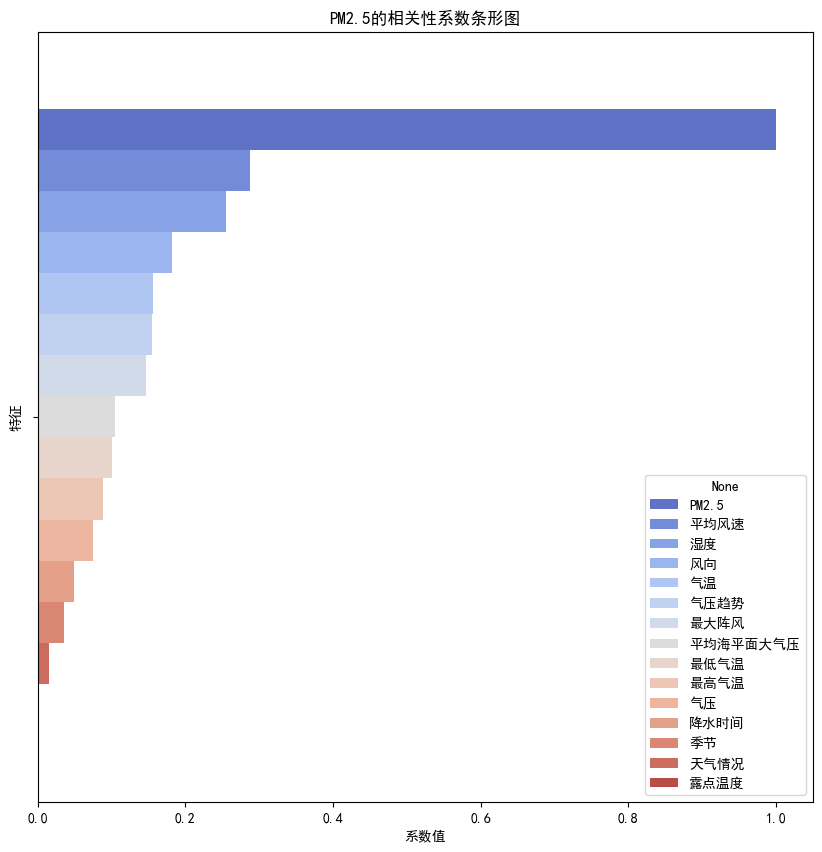


PM10的相关性分析结果：

PM10        1.000000
平均风速        0.183021
气压趋势        0.160852
气温          0.124652
风向          0.116126
最低气温        0.104165
最大阵风        0.087421
露点温度        0.071516
最高气温        0.056746
平均海平面大气压    0.052922
湿度          0.049332
天气情况        0.035941
降水时间        0.033476
气压          0.027195
季节          0.016593
Name: PM10, dtype: float64


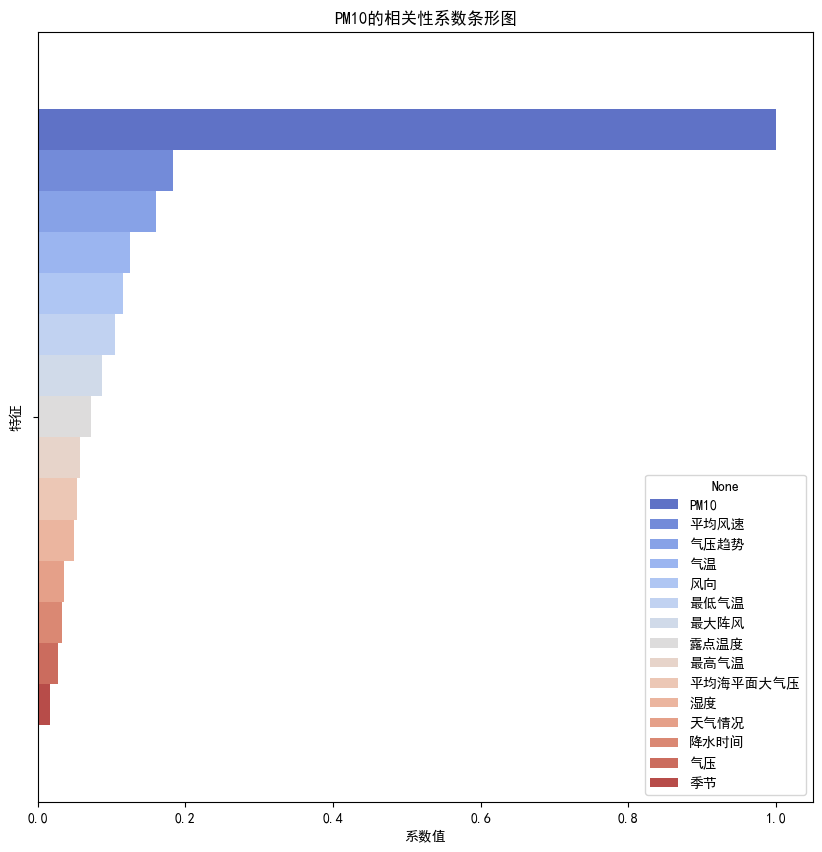


NO2的相关性分析结果：

NO2         1.000000
气温          0.313374
平均风速        0.305270
平均海平面大气压    0.297695
气压          0.253524
最低气温        0.227680
露点温度        0.223513
最高气温        0.197564
气压趋势        0.167140
风向          0.118285
最大阵风        0.115511
降水时间        0.100632
天气情况        0.099558
湿度          0.011815
季节          0.011596
Name: NO2, dtype: float64


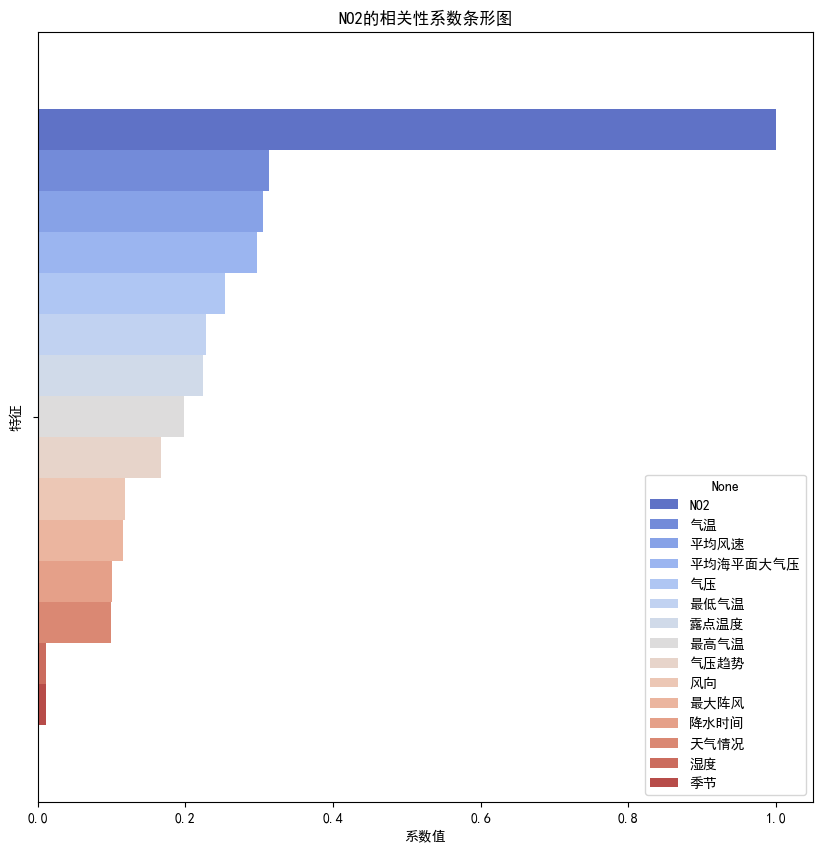


CO的相关性分析结果：

CO          1.000000
平均风速        0.290830
气温          0.247104
湿度          0.232125
风向          0.213775
平均海平面大气压    0.178089
季节          0.156474
气压          0.142585
最大阵风        0.119038
气压趋势        0.102697
天气情况        0.085846
最高气温        0.080423
露点温度        0.077970
降水时间        0.074248
最低气温        0.073578
Name: CO, dtype: float64


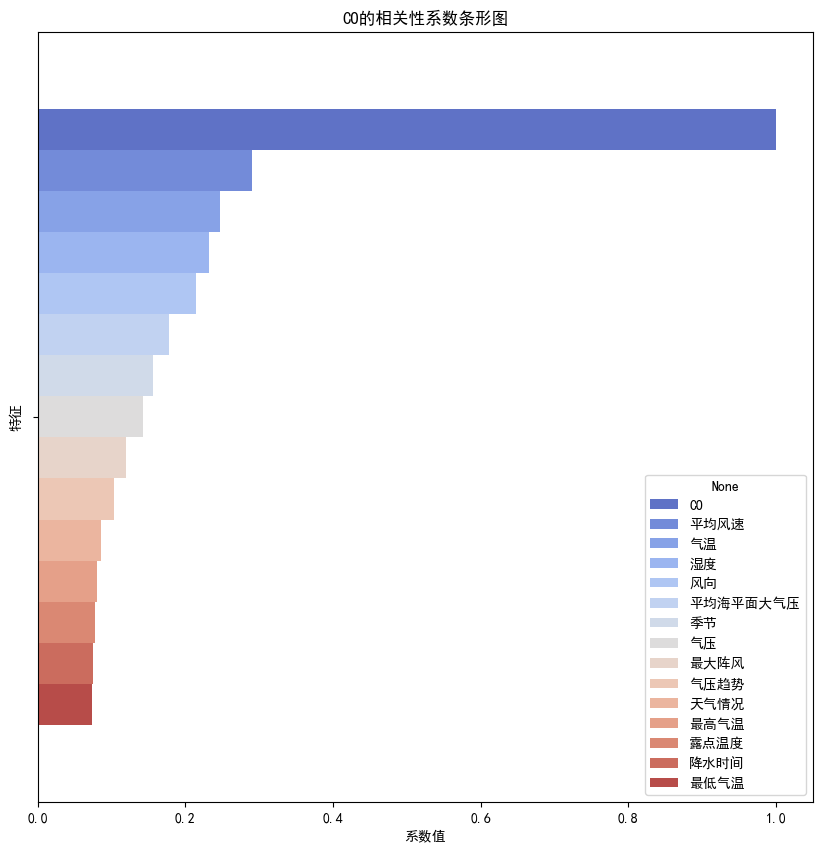


SO2的相关性分析结果：

SO2         1.000000
气温          0.306540
露点温度        0.254694
平均海平面大气压    0.233613
季节          0.227524
气压          0.198480
风向          0.131312
平均风速        0.075902
湿度          0.075378
最低气温        0.073285
最高气温        0.072347
气压趋势        0.066544
降水时间        0.013580
天气情况        0.011971
最大阵风        0.003593
Name: SO2, dtype: float64


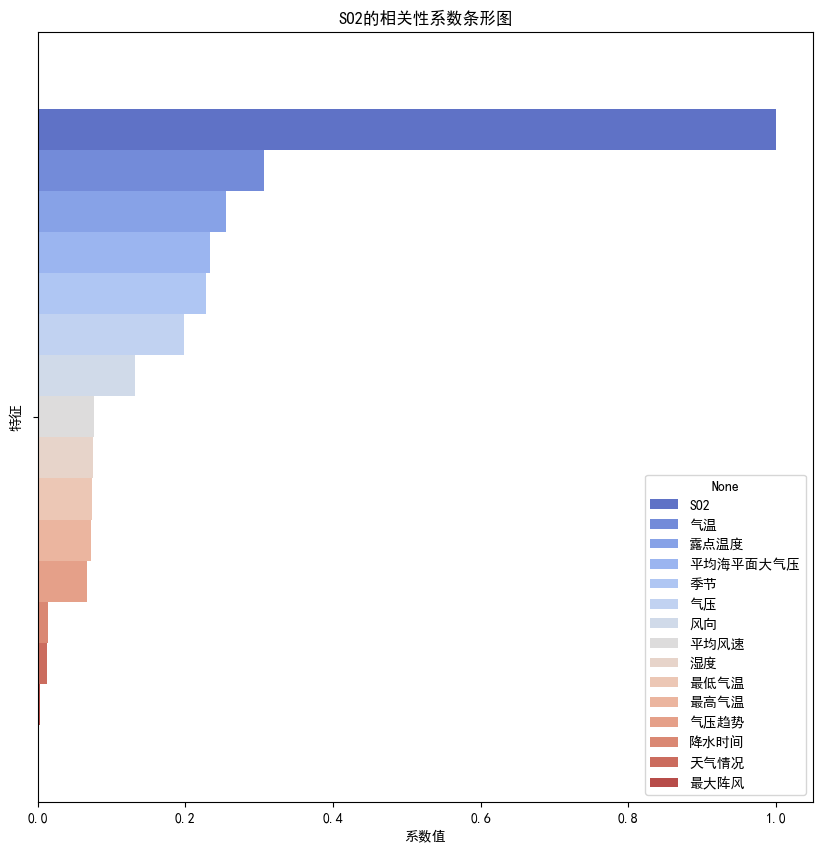


O3_8h的相关性分析结果：

O3_8h       1.000000
气温          0.740916
平均海平面大气压    0.685109
气压          0.682996
露点温度        0.616646
最高气温        0.500138
最低气温        0.460675
降水时间        0.140944
湿度          0.113398
季节          0.060095
平均风速        0.059269
气压趋势        0.026255
天气情况        0.007104
最大阵风        0.004726
风向          0.001602
Name: O3_8h, dtype: float64


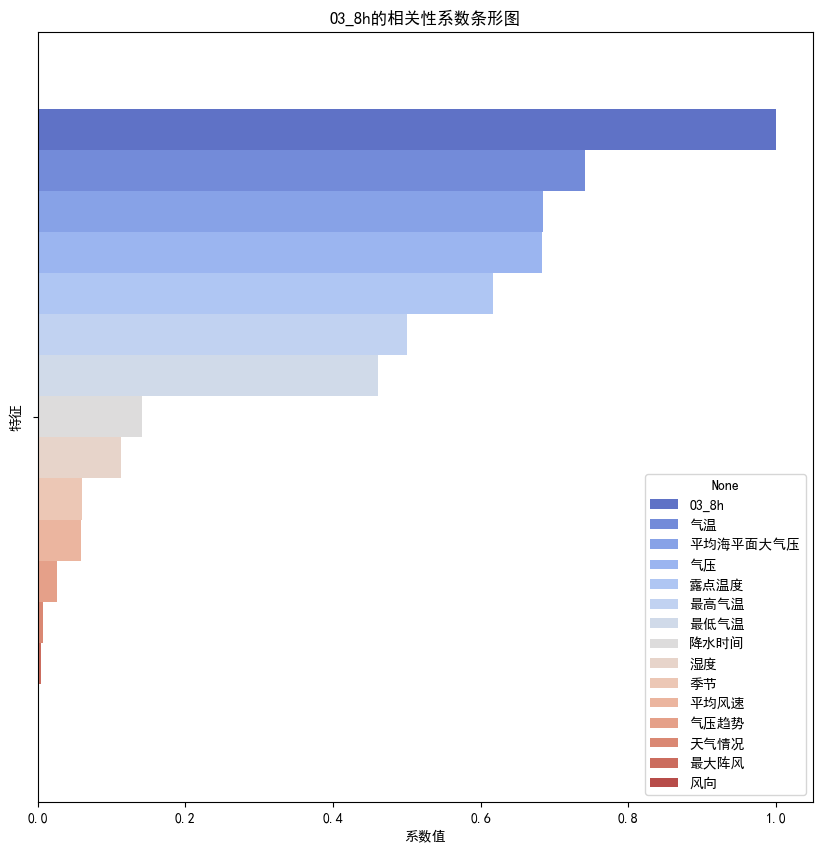

In [76]:
# 定义你需要的列
columns = ['气温', '气压', '平均海平面大气压', '气压趋势', '湿度', '风向', '平均风速', '最大阵风', '天气情况', '最低气温', '最高气温', '露点温度', '降水时间', '季节', 'PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3_8h']

# 初始化编码器
encoder = LabelEncoder()

# 对"季节"进行标签编码
merged_data['季节'] = encoder.fit_transform(merged_data['季节'])

# 目标列列表
targets = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3_8h']

# 对每个目标列进行相关性分析
for target in targets:

    # 暂时移除其他目标列
    temp_columns = [c for c in columns if c not in targets or c == target]

    # 选择这些列进行相关性分析
    selected_data = merged_data[temp_columns]
    correlation = selected_data.corr()

    # 找到与目标列相关的列并按相关性的绝对值进行降序排列
    target_correlation_abs = correlation[target].abs().sort_values(ascending=False)

    # 打印结果
    print(f'\n{target}的相关性分析结果：\n')
    print(target_correlation_abs)

    # 创建一个新的图像并设置其大小
    plt.figure(figsize=(10,10))

    # 创建颜色映射，使用颜色渐变。取决对系数值的绝对值创建颜色映射，以表示相关性强度
    color_map = colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

    # 创建条形图，并用颜色映射来设置每个条的颜色
    ## sns.barplot(x=target_correlation_abs.values, y=target_correlation_abs.index, palette=sns.color_palette("coolwarm", len(target_correlation_abs)))
    sns.barplot(x=target_correlation_abs.values, hue = target_correlation_abs.index, legend=True, palette=sns.color_palette("coolwarm", len(target_correlation_abs)))

    # 添加标题和标签
    plt.title(f'{target}的相关性系数条形图')
    plt.xlabel('系数值')
    plt.ylabel('特征')

    # 显示图像
    plt.show()


In [77]:
merged_data

,日期,气温,气压,平均海平面大气压,气压趋势,湿度,风向,平均风速,最大阵风,天气情况,...,降水时间,季节,AQI,质量等级,PM2.5,PM10,NO2,CO,SO2,O3_8h
0,2013-12-02,3.162,759.712,764.462,-0.013,45.875,7.375,1.375,7.177,5.500,...,10.717,0,142,轻度污染,109,138,88,2.6,61,11
1,2013-12-03,5.488,761.725,766.425,0.100,39.000,8.000,1.625,7.177,4.750,...,10.717,0,86,良,64,86,54,1.6,38,45
2,2013-12-04,5.250,760.300,764.988,-0.138,45.375,9.375,1.250,7.177,1.750,...,10.717,0,109,轻度污染,82,101,62,2.0,42,23
3,2013-12-05,6.150,763.275,767.975,0.250,30.000,6.875,2.250,7.177,3.875,...,10.717,0,56,良,39,56,38,1.2,30,52
4,2013-12-06,2.925,760.325,765.075,-0.275,52.750,4.875,1.250,7.177,1.000,...,10.717,0,169,中度污染,128,162,78,2.5,48,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,2023-12-26,-2.050,770.638,773.938,0.925,54.125,8.250,1.500,7.147,0.500,...,12.000,0,55,良,26,46,44,0.7,3,0
3677,2023-12-27,-3.888,771.538,774.850,-0.538,67.750,7.250,1.125,4.250,0.000,...,12.000,0,64,良,45,71,51,0.8,3,34
3678,2023-12-28,-3.012,769.138,772.438,-0.038,69.875,6.625,1.000,3.750,0.375,...,12.000,0,129,轻度污染,98,132,69,1.2,3,21
3679,2023-12-29,-2.800,765.112,768.400,-0.938,78.125,5.625,1.125,4.147,2.000,...,12.000,0,150,轻度污染,115,145,62,1.2,3,45


构建合适的特征变量组，从各个目标的最相关特征值中按照频次提取出最常见的特征

In [7]:
from collections import Counter

feature_dict = {
    'PM2.5': ['平均风速', '湿度', '风向', '气温', '气压趋势', '最大阵风', '平均海平面大气压', '最低气温'],
    'PM10': ['平均风速', '气压趋势', '气温', '风向', '最低气温'],
    'NO2': ['气温', '平均风速', '平均海平面大气压', '气压', '最低气温', '露点温度', '最高气温', '气压趋势', '风向', '最大阵风', '降水时间'],
    'CO': ['平均风速', '气温', '湿度', '风向', '平均海平面大气压', '季节', '气压', '最大阵风', '气压趋势'],
    'SO2': ['气温', '露点温度', '平均海平面大气压', '季节', '气压', '风向'],
    'O3_8h': ['气温', '平均海平面大气压', '气压', '露点温度', '最高气温', '最低气温', '降水时间', '湿度']
}

# 提取所有特征
all_features = [feature for sublist in feature_dict.values() for feature in sublist]

# 计算每个特征的频率
feature_counts = Counter(all_features)

# 提取最常见的特征
common_features = [feature[0] for feature in feature_counts.most_common()]

#添加到feature_cols
feature_cols = common_features + ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3_8h']

feature_cols

['气温',
 '风向',
 '平均海平面大气压',
 '平均风速',
 '气压趋势',
 '最低气温',
 '气压',
 '湿度',
 '最大阵风',
 '露点温度',
 '最高气温',
 '降水时间',
 '季节',
 'PM2.5',
 'PM10',
 'NO2',
 'CO',
 'SO2',
 'O3_8h']

时间序列模型预测未来数据, 通过调整参数发现设置时序步长为1时，预测效果最好

In [73]:


# 特征和目标变量选择
feature_cols = ['气温', '平均风速', '平均海平面大气压', '气压', '最低气温', '露点温度', '最高气温', '气压趋势', '风向', '最大阵风', '降水时间','季节','PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3_8h'] 
target_cols = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3_8h']

X = merged_data[feature_cols].values
y = merged_data[target_cols].values

# 数据规范化
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 转换输入形状为(samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.Tensor(x)
        output, (hn, cn) = self.lstm(x)
        hn = hn.view(-1, self.hidden_dim)
        out = self.fc(hn)
        return out
    
model = LSTMModel(X_train.shape[2], 128, len(target_cols))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-8) # 加入了权重衰减项

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model.forward(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, torch.Tensor(y_train))
    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:  # print loss every 1 epochs
        print(f'Epoch: {epoch} \tLoss: {loss.item()}')

with torch.no_grad():
    y_train_pred = model.forward(X_train)
    y_test_pred = model.forward(X_test)
train_loss = criterion(y_train_pred, torch.Tensor(y_train)).item() 
test_loss = criterion(y_test_pred, torch.Tensor(y_test)).item()

# 训练集和测试集上的损失
print("Train loss: %.3f" % train_loss)
print("Test loss: %.3f" % test_loss)


# 获取预测结果，并进行反归一化
y_train_pred = model(X_train).detach().numpy()
y_test_pred = model(X_test).detach().numpy()
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# 对真实结果进行反归一化
y_train_real = scaler.inverse_transform(y_train)
y_test_real = scaler.inverse_transform(y_test)

# 为预测结果和真实结果创建DataFrame
train_dict = {}
test_dict = {}
for idx, col in enumerate(target_cols):
    train_dict[col+'_pred'] = y_train_pred[:, idx]
    train_dict[col+'_real'] = y_train_real[:, idx]
    test_dict[col+'_pred'] = y_test_pred[:, idx]
    test_dict[col+'_real'] = y_test_real[:, idx]
train_result = pd.DataFrame(train_dict)
test_result = pd.DataFrame(test_dict)

# 计算RMSE
train_rmse = np.sqrt(train_loss)
test_rmse = np.sqrt(test_loss)

print("Train RMSE: %.3f" % train_rmse)
print("Test RMSE: %.3f" % test_rmse)

# 训练集的R2 score
r2_train = r2_score(y_train_real, y_train_pred)
print("Train R^2: %.3f" % r2_train)

# 测试集的R2 score
r2_test = r2_score(y_test_real, y_test_pred)
print("Test R^2: %.3f" % r2_test)

# 显示结果
test_result.to_csv('测试集结果.csv')

# 使用全量的数据进行预测
all_data = X  # 注意我们直接使用了全部的X数据

all_data = np.reshape(all_data, (all_data.shape[0], 1, all_data.shape[1]))  # 调整数据形状以符合模型输入要求
with torch.no_grad():
    all_data_pred = model(all_data)  # 使用模型进行预测
    
all_data_pred = all_data_pred.detach().numpy()
all_data_pred = scaler.inverse_transform(all_data_pred)  # 将预测数据进行反归一化

# 获取未来xx天的预测数据
last_30_days_predictions = all_data_pred[-30:, :]
predictions_df = pd.DataFrame(last_30_days_predictions, columns=target_cols)
predictions_df = predictions_df.select_dtypes(include=['int', 'float','float64']).astype(float)
predictions_df = predictions_df.round(3)   ##保留三位小数
predictions_df[predictions_df<0] = 0   ## 去除负数

predictions_df.to_csv('pred.csv')

test_result

Epoch: 0 	Loss: 0.05135798081755638
Epoch: 1 	Loss: 0.02839781530201435
Epoch: 2 	Loss: 0.016113687306642532
Epoch: 3 	Loss: 0.016999082639813423
Epoch: 4 	Loss: 0.01941831223666668
Epoch: 5 	Loss: 0.01598874107003212
Epoch: 6 	Loss: 0.0125363077968359
Epoch: 7 	Loss: 0.011275854893028736
Epoch: 8 	Loss: 0.011477886699140072
Epoch: 9 	Loss: 0.011593358591198921
Epoch: 10 	Loss: 0.010698792524635792
Epoch: 11 	Loss: 0.00885187741369009
Epoch: 12 	Loss: 0.006819393951445818
Epoch: 13 	Loss: 0.005657379049807787
Epoch: 14 	Loss: 0.005841752979904413
Epoch: 15 	Loss: 0.0063661630265414715
Epoch: 16 	Loss: 0.006231017876416445
Epoch: 17 	Loss: 0.005317238159477711
Epoch: 18 	Loss: 0.0044114477932453156
Epoch: 19 	Loss: 0.004088129848241806
Epoch: 20 	Loss: 0.004017444793134928
Epoch: 21 	Loss: 0.004092128947377205
Epoch: 22 	Loss: 0.0042104036547243595
Epoch: 23 	Loss: 0.004159535281360149
Epoch: 24 	Loss: 0.003882958786562085
Epoch: 25 	Loss: 0.003505514934659004
Epoch: 26 	Loss: 0.0032902

,PM2.5,PM10,NO2,CO,SO2,O3_8h
0,20.028,64.258,39.137,0.504,2.945,50.756
1,26.939,75.089,50.608,0.762,3.785,30.318
2,52.524,108.966,60.452,1.025,5.406,19.986
3,65.899,132.577,64.201,1.164,5.503,16.861
4,49.892,131.244,31.125,0.389,0.666,58.273
5,90.298,239.567,66.898,0.805,2.106,24.799
6,92.516,205.783,68.467,1.138,5.268,22.757
7,38.483,100.917,41.769,0.742,4.134,34.216
8,28.549,55.907,37.320,0.818,6.526,25.264
9,24.378,40.951,29.846,0.598,1.508,40.545


预测出的未来30天的天气数据

In [78]:
predictions_df

,PM2.5_pred,PM2.5_real,PM10_pred,PM10_real,NO2_pred,NO2_real,CO_pred,CO_real,SO2_pred,SO2_real,O3_8h_pred,O3_8h_real
0,255.032242,252.0,286.326782,284.0,103.918800,104.0,3.555039,3.6,19.169731,18.0,14.733067,17.0
1,16.147196,16.0,21.093147,26.0,14.009613,12.0,0.575228,0.6,2.687299,3.0,73.274734,71.0
2,21.643280,22.0,37.565376,40.0,18.204142,18.0,0.538776,0.6,2.335364,2.0,158.245499,159.0
3,7.084776,14.0,14.412367,18.0,21.320280,17.0,0.516430,0.5,1.557946,3.0,59.936474,55.0
4,36.402050,43.0,55.924442,47.0,30.375290,28.0,0.582165,0.6,1.917138,2.0,59.806278,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...
732,21.324646,28.0,82.742050,75.0,38.901691,41.0,0.362075,0.4,5.169958,5.0,137.524170,142.0
733,7.468739,16.0,28.242886,21.0,36.996555,34.0,0.649301,0.6,16.727779,19.0,43.595615,40.0
734,-0.949099,5.0,5.717364,16.0,20.199593,13.0,0.202129,0.2,0.196494,2.0,64.860527,63.0
735,10.729000,18.0,49.965919,47.0,47.243847,48.0,0.469539,0.5,2.898273,3.0,67.429390,70.0


通过各项指标计算预测数据的最终的AQI

In [74]:
# 首先，我们需要定义一个函数来计算每个污染物对应的子AQI
def cal_IAQI(pollutant, concentration):
    standard = {
        'PM2.5': [(0, 35), (36, 75), (76, 115), (116, 150), (151, 250), (251, 350), (350, 500)],
        'PM10': [(0, 50), (51, 150), (151, 250), (251, 350), (351, 420), (421, 500), (501, 600)],
        'SO2': [(0, 50), (51, 150), (151, 475), (476, 800), (801, 1600), (1601, 2100), (2101, 2620)],
        'NO2': [(0, 40), (41, 80), (81, 180), (181, 280), (281, 565), (566, 750), (751, 940)],
        'CO': [(0, 5), (6, 10), (11, 35), (36, 60), (61, 90), (91, 120), (121, 150)],
        'O3_8h': [(0, 100), (101, 160), (161, 215), (216, 265), (266, 800)]}

    IAQI = [(0, 50), (51, 100), (101, 150), (151, 200), (201, 300), (301, 400), (401, 500)]
    
    standard_values = standard[pollutant]
    for i in range(len(standard_values)):
        if standard_values[i][0] <= concentration <= standard_values[i][1]:
            return IAQI[i][0] + (IAQI[i][1] - IAQI[i][0]) * (concentration - standard_values[i][0]) / (standard_values[i][1] - standard_values[i][0])
    
    # 如果浓度超出了预定的任何一个区间，就返回一个非常大的值
    return 10000

# 计算总的AQI
def cal_AQI(row):
    pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3_8h']
    max_IAQI = 0
    for pollutant in pollutants:
        concentration = row[pollutant]
        IAQI = cal_IAQI(pollutant, concentration)
        max_IAQI = max(max_IAQI, IAQI)
    return max_IAQI

# 在DataFrame上应用这个函数


predictions_df['calculated_AQI'] = predictions_df.apply(cal_AQI, axis=1)
predictions_df

,PM2.5,PM10,NO2,CO,SO2,O3_8h,calculated_AQI
0,20.028,64.258,39.137,0.504,2.945,50.756,57.562040
1,26.939,75.089,50.608,0.762,3.785,30.318,63.071590
2,52.524,108.966,60.452,1.025,5.406,19.986,79.690242
3,65.899,132.577,64.201,1.164,5.503,16.861,91.376495
4,49.892,131.244,31.125,0.389,0.666,58.273,90.716727
5,90.298,239.567,66.898,0.805,2.106,24.799,144.836192
6,92.516,205.783,68.467,1.138,5.268,22.757,128.114818
7,38.483,100.917,41.769,0.742,4.134,34.216,75.706394
8,28.549,55.907,37.320,0.818,6.526,25.264,53.428717
9,24.378,40.951,29.846,0.598,1.508,40.545,40.951000
